# Intro to Object Detection Colab

Welcome to the object detection colab!  This demo will take you through the steps of running an "out-of-the-box" detection model on a collection of images.

## Setup

In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

## Import and start

In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf



%matplotlib inline

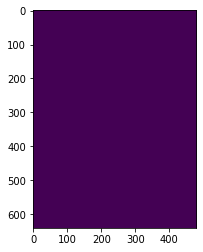

In [2]:
foo = np.zeros((640,480))
plt.imshow(foo)

## Utilities

In [3]:
from utilities import *

In [4]:
from bricks.CenterNet import CenterNet
import os
# @title Choose the model to use, then evaluate the cell.
MODELS = {
    'centernet_with_keypoints': 'center_net_hg104_512x512_kpts_coco17_tpu-32', 
    'centernet_without_keypoints': 'center_net_hg104_512x512_coco17_tpu-8'
}

model_display_name = 'centernet_with_keypoints' # @param ['centernet_with_keypoints', 'centernet_without_keypoints']
model_name = MODELS[model_display_name]

# Download the checkpoint and put it into models/research/object_detection/test_data/

if model_display_name == 'centernet_with_keypoints':
    if(not os.path.exists("centernet_hg104_512x512_kpts_coco17_tpu-32")):
        !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
        !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
        !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
    model_instance = CenterNet(
        pipeline_config = 'models/research/object_detection/configs/tf2/center_net_hourglass104_512x512_coco17_tpu-8.config', 
        model_dir = 'models/research/object_detection/test_data/checkpoint/'
    )
if model_display_name == 'centernet_without_keypoints':
    if(not os.path.exists("centernet_hg104_512x512_kpts_coco17_tpu-32")):
        !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
        !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz
        !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/
    model_instance = CenterNet(
        pipeline_config = '../models/research/object_detection/configs/tf2/center_net_hourglass104_512x512_coco17_tpu-8.config', 
        model_dir = '../models/research/object_detection/test_data/checkpoint/'
    )

Instructions for updating:
Use `tf.cast` instead.
(2160, 3840)
{}


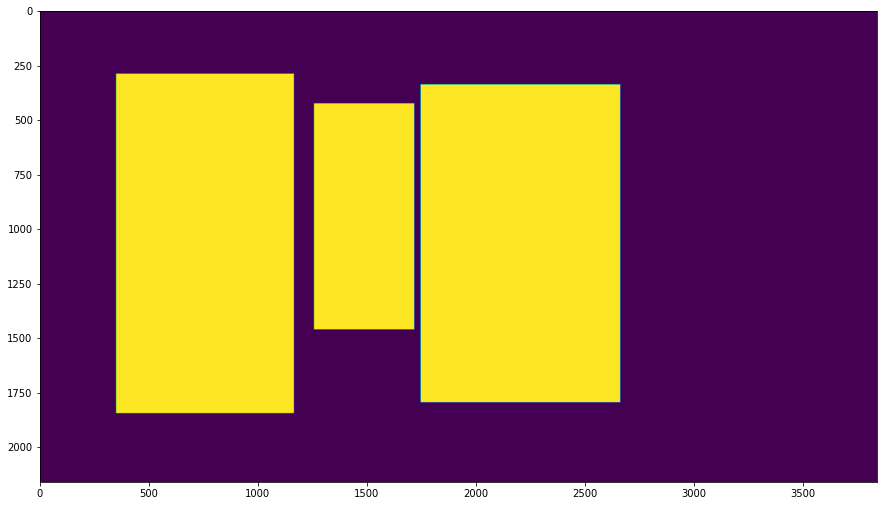

In [5]:
image_path = '../data/imagecrop/fantastic-four-movie-wallpaper-ultra-hd-4k-70140.jpg'
image_np = load_image_into_numpy_array(image_path)
pil_im = Image.open(image_path)

detections, predictions_dict, shapes = model_instance.run_inference(image_np)
#image_np_with_detections = model_instance.show_detections(image_np,detections)
image_np_with_detections = model_instance.show_detections(image_np,detections)
label_map_dict, label_map_path, category_index = model_instance.load_label_map()

detected_classes_text = {}

classes_weight = {
    "kite": 100,
    "person": 1,
    "surfboard":1
}

#test_image = 'models/research/object_detection/test_images/image2.jpg'
orig_im = Image.open(image_path)
im_width, im_height = pil_im.size
pil_im = Image.new('L', (im_width, im_height))

np_im = np.asarray(pil_im).copy()
print(np_im.shape)

scores = detections['detection_scores'][0].numpy()
classes_detected = (detections['detection_classes'][0].numpy() + 1).astype(int)

for idx, bbox in enumerate(detections['detection_boxes'][0].numpy()):  
    if scores[idx] > 0.30:
        ymin, xmin, ymax, xmax = tuple(bbox.tolist())
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)

        obj_score = classes_weight[category_index[classes_detected[idx]]['name']]
        np_im[int(top):int(bottom),int(left):int(right)] = obj_score

        #detected_classes_text[STANDARD_COLORS[classes_detected[idx]]] = category_index[classes_detected[idx]]['name']

plt.figure(figsize=(15,20))
plt.imshow(np_im)

print(detected_classes_text)


In [15]:
def make_crop_coordinates_nhz(image, ratio_str):
    if ratio_str == "16_9":
        ratio = 0.5625
    if ratio_str == "4_3":
        ratio = 0.75
    if ratio_str == "1_1":
        ratio = 1
    if ratio_str == "9_16":
        ratio = 1.7777
    if ratio_str == "3_4":
        ratio = 0.75
    height = image.shape[0]
    width = image.shape[1]
    coodinates = []
    shorter_dimension = min(width, height)
    position_step = shorter_dimension / 80
    sizes = [width * 0.9, width]
    for size in sizes:
        position_width = 0
        crop_height = int(size * ratio)
        while True:
            position_height = 0
            while True:
                new_coord = (position_width, position_height,
                                   position_width + int(size), position_height + crop_height)
                coodinates.append(new_coord)
                #print(new_coord)
                #print("INCREASING HEIGHT")
                position_height += position_step
                if position_height + crop_height > height:
                    break
            position_width += position_step
            #print("INCREASING WIDTH")
            if position_width + size > width:
                #print("**********************")
                break
    return coodinates

BEST: (0, 0, 3456, 3456)


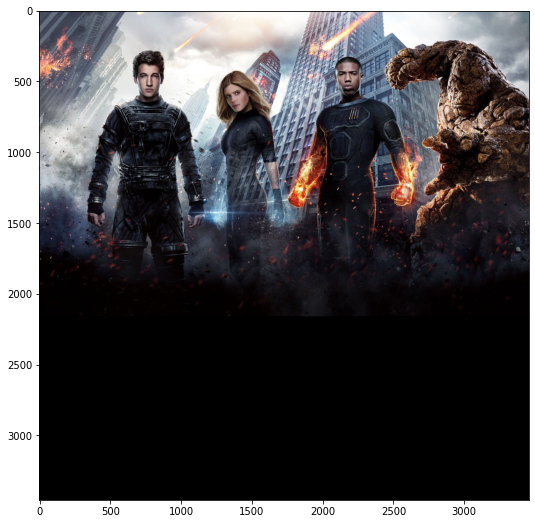

In [18]:
crops = make_crop_coordinates_nhz(np_im,"1_1")

best_score = -1
best_crop = []

for crop in crops:
    #TODO: add rule of thirds, avoid partial classes crop,etc.. to the score
    candidate_score = np.sum(np_im[int(crop[1]):int(crop[3]),int(crop[0]):int(crop[2])])
    #print(crop)
    #print(candidate_score)
    if best_score < candidate_score:
        best_crop = crop
        best_score = candidate_score
        
print("BEST:",best_crop)
plt.figure(figsize=(16,9))
#plt.imshow(np_im[int(best_crop[1]):int(best_crop[3]),int(best_crop[0]):int(best_crop[2])])
plt.imshow(orig_im.crop(best_crop))